In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

## Transforms
To see all examples of transforms, check out official documentation - https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

In [4]:
image_datasets = {
    'train': datasets.CIFAR10('../datasets', train = True, transform = data_transforms['train']),
    'val': datasets.CIFAR10('../datasets', train = False, transform = data_transforms['val'])
}

In [5]:
image_datasets

{'train': Dataset CIFAR10
     Number of datapoints: 50000
     Root location: datasets
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.4914 0.4822 0.4465], std=[0.2023 0.1994 0.201 ])
            ),
 'val': Dataset CIFAR10
     Number of datapoints: 10000
     Root location: datasets
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.4914 0.4822 0.4465], std=[0.2023 0.1994 0.201 ])
            )}

In [6]:
dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 256, shuffle=True, num_workers = 4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

In [7]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [9]:
device

device(type='mps')

## Visualizing a few images

In [10]:
def imshow(inputs, title=None):
    inputs = inputs.numpy().transpose((1,2,0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    plt.imshow(inputs)
    if title:
        plt.title(title)

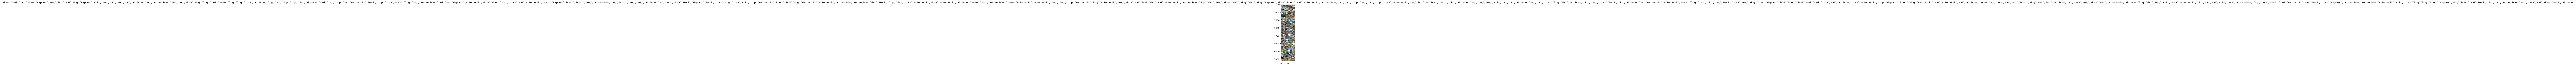

In [11]:
inputs, labels = next(iter(dataloader['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in labels])

In [12]:
inputs.size(0)

256

In [13]:
print(labels.data)
for label in labels:
    print(class_names[label.item()], end=' ')

tensor([4, 2, 3, 7, 0, 6, 2, 3, 5, 0, 8, 6, 3, 6, 3, 0, 5, 1, 2, 5, 4, 5, 6, 2,
        7, 6, 6, 9, 0, 6, 3, 8, 5, 2, 0, 2, 5, 8, 3, 1, 9, 8, 9, 9, 6, 5, 1, 2,
        3, 0, 1, 4, 4, 4, 9, 3, 1, 9, 0, 7, 7, 6, 1, 5, 7, 6, 6, 0, 3, 4, 4, 9,
        0, 9, 9, 5, 9, 8, 8, 1, 7, 2, 5, 1, 1, 1, 1, 8, 9, 6, 2, 9, 1, 4, 1, 0,
        7, 4, 1, 7, 1, 1, 6, 6, 8, 1, 6, 1, 6, 4, 3, 2, 8, 3, 1, 1, 8, 8, 6, 4,
        8, 5, 8, 5, 0, 4, 7, 3, 1, 1, 3, 3, 8, 5, 3, 8, 9, 1, 5, 2, 0, 7, 2, 0,
        5, 5, 6, 8, 3, 3, 0, 5, 3, 9, 6, 8, 0, 2, 6, 9, 9, 2, 0, 3, 1, 1, 9, 6,
        4, 2, 5, 9, 9, 6, 5, 4, 0, 2, 7, 2, 2, 2, 9, 3, 0, 9, 1, 8, 0, 7, 5, 1,
        3, 1, 3, 0, 7, 3, 4, 3, 2, 7, 5, 8, 2, 0, 3, 4, 6, 4, 8, 1, 0, 6, 8, 6,
        8, 4, 1, 2, 3, 3, 8, 4, 1, 6, 4, 9, 2, 1, 3, 9, 9, 0, 1, 1, 1, 8, 9, 6,
        6, 7, 0, 5, 7, 3, 9, 2, 3, 1, 4, 4, 3, 4, 9, 0])
deer bird cat horse airplane frog bird cat dog airplane ship frog cat frog cat airplane dog automobile bird dog deer dog frog bird horse frog f

In [11]:
dataset_sizes

{'train': 50000, 'val': 10000}

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    tic = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        # Each epoch has a training and a validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Sets model to training mode
            else:
                model.eval() # Sets model to eval mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward pass
                # Track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass + optimize ONLY if train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item()*inputs.size(0) # Multiply loss by batch size
                running_corrects += torch.sum(labels.data == preds)

            if phase == 'train':
                scheduler.step() # Learning Rate update
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - tic
    print(f'Training time completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val accuracy = {best_acc:.4f}')

    #loading best model weights
    model.load_state_dict(best_model_weights)
    return(model)

## Visualization
`model.training` variable is a `nn.Module` class attribute, set as -
- `True` by `model.train()`
- `False` by `model.eval()`

In [13]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval() 
    # sets model.training to False
    # now model is in evaluation mode

    images_so_far = 0
    fig = plt.figure(figsize=(20,10))

    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]): # Batch size
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training) # Set to the mode it was in, before calling this function
                    return
        model.train(mode = was_training)

In [15]:
model_ft = models.resnet34(pretrained = True)
num_features = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = True

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_features, 10) # Adding a last fully connected layer for our purpose
model_ft = model_ft.to(device)

/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.8030 Acc: 0.7569
val Loss: 0.3717 Acc: 0.8782

Epoch 2/25
----------
train Loss: 0.2256 Acc: 0.9284
val Loss: 0.2514 Acc: 0.9180

Epoch 3/25
----------
train Loss: 0.1556 Acc: 0.9499
val Loss: 0.2151 Acc: 0.9305

Epoch 4/25
----------
train Loss: 0.1192 Acc: 0.9625
val Loss: 0.2018 Acc: 0.9308

Epoch 5/25
----------
train Loss: 0.0970 Acc: 0.9692
val Loss: 0.1875 Acc: 0.9361

Epoch 6/25
----------
train Loss: 0.0791 Acc: 0.9761
val Loss: 0.1805 Acc: 0.9381

Epoch 7/25
----------
train Loss: 0.0633 Acc: 0.9820
val Loss: 0.1773 Acc: 0.9397

Epoch 8/25
----------
train Loss: 0.0508 Acc: 0.9868
val Loss: 0.1749 Acc: 0.9402

Epoch 9/25
----------
train Loss: 0.0498 Acc: 0.9874
val Loss: 0.1753 Acc: 0.9396

Epoch 10/25
----------
train Loss: 0.0487 Acc: 0.9878
val Loss: 0.1782 Acc: 0.9388

Epoch 11/25
----------
train Loss: 0.0468 Acc: 0.9887
val Loss: 0.1758 Acc: 0.9399

Epoch 12/25
----------
train Loss: 0.0461 Acc: 0.9887
val Loss: 0.1760 Acc: 0.9403

E

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x30cfcacc0>
    label = <none> 
    device = <AGXG13XDevice: 0x10eacce00>
        name = Apple M1 Max 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x10eace400>
        label = <none> 
        device = <AGXG13XDevice: 0x10eacce00>
            name = Apple M1 Max 
    retainedReferences = 1


In [1]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [19]:
#torch.save(model_ft, 'models/CIFAR10_resnet-34_full_train.pt')

# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are not computed in `backward()`

In [18]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.3776 Acc: 0.5906
val Loss: 1.0517 Acc: 0.6898

Epoch 2/25
----------
train Loss: 0.8235 Acc: 0.7576
val Loss: 0.8955 Acc: 0.7182

Epoch 3/25
----------
train Loss: 0.7190 Acc: 0.7771
val Loss: 0.8318 Acc: 0.7312

Epoch 4/25
----------
train Loss: 0.6672 Acc: 0.7872
val Loss: 0.8111 Acc: 0.7327

Epoch 5/25
----------
train Loss: 0.6399 Acc: 0.7914
val Loss: 0.7846 Acc: 0.7366

Epoch 6/25
----------
train Loss: 0.6191 Acc: 0.7963
val Loss: 0.7646 Acc: 0.7433

Epoch 7/25
----------
train Loss: 0.6013 Acc: 0.8026
val Loss: 0.7617 Acc: 0.7444

Epoch 8/25
----------
train Loss: 0.5944 Acc: 0.8041
val Loss: 0.7481 Acc: 0.7479

Epoch 9/25
----------
train Loss: 0.5897 Acc: 0.8054
val Loss: 0.7518 Acc: 0.7461

Epoch 10/25
----------
train Loss: 0.5921 Acc: 0.8050
val Loss: 0.7528 Acc: 0.7453

Epoch 11/25
----------
train Loss: 0.5917 Acc: 0.8038
val Loss: 0.7473 Acc: 0.7479

Epoch 12/25
----------
train Loss: 0.5887 Acc: 0.8052
val Loss: 0.7470 Acc: 0.7468

E

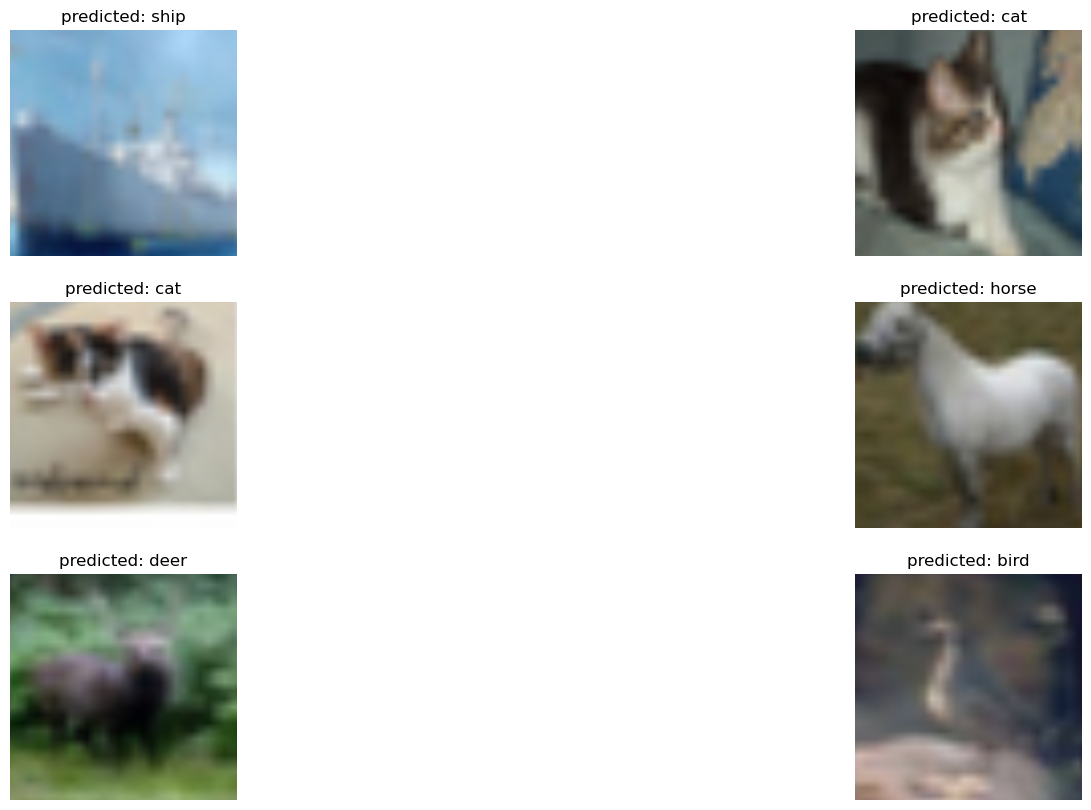

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [21]:
# torch.save(model_conv, 'models/CIFAR10_resnet-34_last_layer_train.pt')